In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

# Try to use GPU, fallback to CPU if busy/unavailable
try:
    if torch.cuda.is_available():
        # Test if GPU is actually accessible
        torch.cuda.empty_cache()
        test_tensor = torch.zeros(1).cuda()
        del test_tensor
        print("GPU device:", torch.cuda.get_device_name(0))
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
except RuntimeError as e:
    print(f"GPU unavailable ({e}), falling back to CPU")
    device = torch.device('cpu')

print("Using device:", device)


PyTorch version: 2.6.0+cu124
CUDA available: True
GPU unavailable (CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
), falling back to CPU
Using device: cpu


In [35]:
data = pd.read_csv("data.csv")
print("✅ Data loaded:", data.shape)
print(data.head())
# Remove rows with any NaN
data = data.dropna()
print('NaN rows removed. New shape:', data.shape)

# Features and labels
X = data[['Speed','Ax','Ay','Az','Gx','Gy','Gz']].values
y = data['Label'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Classes:", label_encoder.classes_)

# Standardize features first (per-sensor across dataset)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape into sequences (LSTM expects 3D: samples, timesteps, features)
# Reduced time steps for faster training while maintaining accuracy
n_time_steps = 40  # reduced from 50 for faster training
n_features = X_scaled.shape[1]
step_size = 10  # increased stride from 5 to reduce data volume (faster training)

X_seq, y_seq = [], []
for i in range(0, len(X_scaled) - n_time_steps, step_size):
    X_seq.append(X_scaled[i:i + n_time_steps])
    y_seq.append(y_encoded[i + n_time_steps - 1])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)
print("✅ Sequence shape:", X_seq.shape, y_seq.shape)

# Train/Val/Test Split (do split BEFORE augmentation)
N = len(X_seq)
train_end = int(0.70 * N)
val_end = int(0.85 * N)

X_train = X_seq[:train_end]
y_train = y_seq[:train_end]

X_val = X_seq[train_end:val_end]
y_val = y_seq[train_end:val_end]

X_test = X_seq[val_end:]
y_test = y_seq[val_end:]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Analyze class distribution on training set
train_counts = Counter(y_train)
class_names = label_encoder.classes_
print("Training class counts:")
for i, name in enumerate(class_names):
    print(f" - {name}: {train_counts.get(i,0)}")

# Aggressive augmentation specifically for STRAIGHT class
def augment_class(X, y, class_idx, target_n, noise_scale=0.02):
    """Return augmented (X_aug, y_aug) to reach target_n samples for class_idx."""
    idxs = np.where(y == class_idx)[0]
    if len(idxs) == 0:
        return np.empty((0,) + X.shape[1:]), np.empty((0,), dtype=y.dtype)
    need = max(0, target_n - len(idxs))
    if need == 0:
        return np.empty((0,) + X.shape[1:]), np.empty((0,), dtype=y.dtype)
    choices = np.random.choice(idxs, size=need, replace=True)
    X_extra = []
    for c in choices:
        sample = X[c].copy()
        noise = np.random.normal(loc=0.0, scale=noise_scale, size=sample.shape)
        X_extra.append(sample + noise)
    X_extra = np.array(X_extra)
    y_extra = np.full((X_extra.shape[0],), class_idx, dtype=y.dtype)
    return X_extra, y_extra

# Upsample to max count
max_count = max(train_counts.values())
print('Upsampling target per class:', max_count)

X_aug_list = [X_train]
y_aug_list = [y_train]
for i in range(len(class_names)):
    cnt = train_counts.get(i, 0)
    # Apply more aggressive augmentation for STRAIGHT
    if class_names[i] == 'STRAIGHT':
        target = int(max_count * 1.5)  # 50% more samples for STRAIGHT
        noise_scale = 0.03  # slightly higher noise for more diversity
    else:
        target = max_count
        noise_scale = 0.02
    
    if cnt < target:
        X_extra, y_extra = augment_class(X_train, y_train, i, target, noise_scale=noise_scale)
        if X_extra.shape[0] > 0:
            X_aug_list.append(X_extra)
            y_aug_list.append(y_extra)
            print(f"Augmented class {class_names[i]}: +{X_extra.shape[0]} samples (noise_scale={noise_scale})")

# Concatenate and shuffle training set
X_train = np.concatenate(X_aug_list, axis=0)
y_train = np.concatenate(y_aug_list, axis=0)
perm = np.random.permutation(len(X_train))
X_train = X_train[perm]
y_train = y_train[perm]

# Recompute training class counts after augmentation
train_counts_after = Counter(y_train)
print("Training class counts after augmentation:")
for i, name in enumerate(class_names):
    print(f" - {name}: {train_counts_after.get(i,0)}")

# Number of classes
n_classes = len(np.unique(y_seq))

# Compute class weights with aggressive weighting for STRAIGHT
class_weights_array = class_weight.compute_class_weight('balanced', classes=np.arange(n_classes), y=y_train)
class_weights_dict = {i: float(class_weights_array[i]) for i in range(len(class_weights_array))}

# Significantly boost STRAIGHT weight
if 'STRAIGHT' in class_names:
    straight_idx = int(np.where(class_names == 'STRAIGHT')[0])
    print('STRAIGHT index:', straight_idx)
    class_weights_dict[straight_idx] *= 2.5  # increased from 1.2 to 2.5

print("Class weights used:", class_weights_dict)

# Convert to PyTorch tensors (keep as numpy for now, will convert in model cell)
# Store original numpy arrays for PyTorch conversion
X_train_np = X_train.astype(np.float32)
y_train_np = y_train.astype(np.int64)
X_val_np = X_val.astype(np.float32)
y_val_np = y_val.astype(np.int64)
X_test_np = X_test.astype(np.float32)
y_test_np = y_test.astype(np.int64)

print(f"✅ Data ready for PyTorch")


✅ Data loaded: (234103, 8)
      Speed        Ax        Ay        Az        Gx        Gy        Gz Label
0  1.883484 -0.036621 -0.175293  1.001465 -1.236641  0.274809  0.198473  STOP
1  1.883484 -0.023193 -0.175781  0.997559 -1.267176  0.190840  0.190840  STOP
2  1.883484 -0.015625 -0.184570  0.986084 -1.351145  0.320611  0.152672  STOP
3  1.883484 -0.033936 -0.197510  1.015625 -1.282443  0.351145  0.137405  STOP
4  1.883484 -0.038574 -0.192871  1.028076 -1.259542  0.190840  0.137405  STOP
NaN rows removed. New shape: (233375, 8)
Classes: ['BUMP' 'LEFT' 'RIGHT' 'STOP' 'STRAIGHT']
✅ Sequence shape: (23334, 40, 7) (23334,)
✅ Sequence shape: (23334, 40, 7) (23334,)
Train: (16333, 40, 7), Val: (3500, 40, 7), Test: (3501, 40, 7)
Training class counts:
 - BUMP: 1209
 - LEFT: 793
 - RIGHT: 899
 - STOP: 1105
 - STRAIGHT: 12327
Upsampling target per class: 12327
Augmented class BUMP: +11118 samples (noise_scale=0.02)
Augmented class LEFT: +11534 samples (noise_scale=0.02)
Train: (16333, 40, 7),

In [36]:
# PyTorch Model - identical architecture to Keras version
class BidirectionalLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rates, l2_reg=1e-4):
        super(BidirectionalLSTMModel, self).__init__()
        self.l2_reg = l2_reg
        
        # First Bidirectional LSTM (128 units each direction = 256 total output)
        self.lstm1 = nn.LSTM(input_size, hidden_sizes[0], batch_first=True, bidirectional=True)
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0] * 2)
        self.dropout1 = nn.Dropout(dropout_rates[0])
        
        # Second Bidirectional LSTM (96 units each direction = 192 total output)
        self.lstm2 = nn.LSTM(hidden_sizes[0] * 2, hidden_sizes[1], batch_first=True, bidirectional=True)
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1] * 2)
        self.dropout2 = nn.Dropout(dropout_rates[1])
        
        # Dense layers
        self.fc1 = nn.Linear(hidden_sizes[1] * 2, 96)
        self.bn3 = nn.BatchNorm1d(96)
        self.dropout3 = nn.Dropout(dropout_rates[2])
        
        self.fc2 = nn.Linear(96, 48)
        self.dropout4 = nn.Dropout(dropout_rates[3])
        
        self.fc3 = nn.Linear(48, num_classes)
        
    def forward(self, x):
        # x shape: (batch, seq_len, features)
        
        # First LSTM layer
        out, _ = self.lstm1(x)
        # out shape: (batch, seq_len, hidden*2)
        # Take only the last timestep for batch norm
        out_last = out[:, -1, :]  # (batch, hidden*2)
        out_last = self.bn1(out_last)
        out_last = self.dropout1(out_last)
        # Expand back to sequence
        out = out_last.unsqueeze(1)  # (batch, 1, hidden*2)
        
        # Second LSTM layer
        out, _ = self.lstm2(out)
        out = out[:, -1, :]  # Take last timestep (batch, hidden*2)
        out = self.bn2(out)
        out = self.dropout2(out)
        
        # Dense layers
        out = torch.relu(self.fc1(out))
        out = self.bn3(out)
        out = self.dropout3(out)
        
        out = torch.relu(self.fc2(out))
        out = self.dropout4(out)
        
        out = self.fc3(out)
        return out
    
    def get_l2_loss(self):
        """Compute L2 regularization loss for all weights"""
        l2_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                l2_loss += torch.sum(param ** 2)
        return self.l2_reg * l2_loss

# Focal Loss implementation in PyTorch
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.5, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        if alpha is not None:
            self.alpha = torch.tensor(alpha, dtype=torch.float32)
        else:
            self.alpha = None
    
    def forward(self, inputs, targets):
        """
        inputs: (batch, num_classes) - raw logits
        targets: (batch,) - class indices
        """
        # Convert to probabilities
        probs = torch.softmax(inputs, dim=1)
        
        # Convert targets to one-hot
        targets_one_hot = torch.zeros_like(probs)
        targets_one_hot.scatter_(1, targets.unsqueeze(1), 1)
        
        # Compute cross entropy
        epsilon = 1e-7
        probs = torch.clamp(probs, epsilon, 1.0 - epsilon)
        ce = -targets_one_hot * torch.log(probs)
        
        # Apply alpha weighting if provided
        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            alpha_factor = targets_one_hot * self.alpha
        else:
            alpha_factor = 1.0
        
        # Compute focal term
        modulating_factor = torch.pow(1.0 - probs, self.gamma)
        
        # Focal loss
        focal_loss = alpha_factor * modulating_factor * ce
        focal_loss = torch.sum(focal_loss, dim=1)
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Initialize model
model = BidirectionalLSTMModel(
    input_size=n_features,
    hidden_sizes=[128, 96],  # matches Keras Bidirectional(LSTM(128)) and Bidirectional(LSTM(96))
    num_classes=n_classes,
    dropout_rates=[0.35, 0.35, 0.25, 0.2],
    l2_reg=1e-4
).to(device)

# Compute per-class alpha with aggressive boost for STRAIGHT
counts = np.array([train_counts_after.get(i, 0) for i in range(n_classes)], dtype=np.float32)
counts = np.where(counts == 0, 1.0, counts)
alpha_vec = (1.0 / counts)
alpha_vec = alpha_vec / np.sum(alpha_vec)

# Boost alpha for STRAIGHT even more
if 'STRAIGHT' in class_names:
    straight_idx = int(np.where(class_names == 'STRAIGHT')[0])
    alpha_vec[straight_idx] *= 3.0  # triple the alpha for STRAIGHT
    alpha_vec = alpha_vec / np.sum(alpha_vec)  # renormalize

print('Per-class alpha vector for focal loss:', alpha_vec)

# Initialize loss and optimizer
criterion = FocalLoss(alpha=alpha_vec, gamma=2.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=4, min_lr=1e-7, verbose=True
)

# Convert class weights to tensor for weighted sampling
class_weights_tensor = torch.tensor([class_weights_dict[i] for i in range(n_classes)], dtype=torch.float32)

print("\n✅ Model Summary:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Per-class alpha vector for focal loss: [0.16666517 0.16666517 0.16666517 0.16666517 0.33333936]

✅ Model Summary:
BidirectionalLSTMModel(
  (lstm1): LSTM(7, 128, batch_first=True, bidirectional=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.35, inplace=False)
  (lstm2): LSTM(256, 96, batch_first=True, bidirectional=True)
  (bn2): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.35, inplace=False)
  (fc1): Linear(in_features=192, out_features=96, bias=True)
  (bn3): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=96, out_features=48, bias=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=48, out_features=5, bias=True)
)

Total parameters: 436,677
Trainable parameters: 436,677

✅ Model Summary:
BidirectionalLSTMModel(
  (lstm1

In [37]:
# Prepare PyTorch datasets and dataloaders
train_dataset = TensorDataset(
    torch.from_numpy(X_train_np),
    torch.from_numpy(y_train_np)
)
val_dataset = TensorDataset(
    torch.from_numpy(X_val_np),
    torch.from_numpy(y_val_np)
)
test_dataset = TensorDataset(
    torch.from_numpy(X_test_np),
    torch.from_numpy(y_test_np)
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Train batches: 530
Val batches: 28
Test batches: 28


In [38]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer, device, class_weights):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Compute focal loss
        loss = criterion(outputs, labels)
        
        # Add L2 regularization
        loss = loss + model.get_l2_loss()
        
        # Apply class weights to loss (sample weighting)
        weights = class_weights[labels].to(device)
        loss = (loss * weights).mean()
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss = loss + model.get_l2_loss()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels)

# Per-class metrics function (replaces callback)
def compute_per_class_metrics(y_true, y_pred, class_names):
    from sklearn.metrics import recall_score
    recalls = recall_score(y_true, y_pred, labels=np.arange(len(class_names)), average=None, zero_division=0)
    
    if 'STRAIGHT' in class_names:
        straight_idx = int(np.where(class_names == 'STRAIGHT')[0])
        print(f"  → STRAIGHT recall: {recalls[straight_idx]:.4f}")
    return recalls

# Training loop with early stopping and LR scheduling
num_epochs = 80
patience = 12
best_val_loss = float('inf')
patience_counter = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("Starting training...")
for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, class_weights_tensor)
    
    # Validate
    val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, device)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Per-class metrics
    compute_per_class_metrics(val_labels, val_preds, class_names)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
        print("  ✓ Best model saved")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
print("\n✅ Training complete! Best model restored.")


Starting training...
Epoch 1/80 - Train Loss: 0.2297, Train Acc: 0.5999 - Val Loss: 0.1220, Val Acc: 0.8271
  → STRAIGHT recall: 0.8660
  ✓ Best model saved
Epoch 1/80 - Train Loss: 0.2297, Train Acc: 0.5999 - Val Loss: 0.1220, Val Acc: 0.8271
  → STRAIGHT recall: 0.8660
  ✓ Best model saved
Epoch 2/80 - Train Loss: 0.1461, Train Acc: 0.6734 - Val Loss: 0.1001, Val Acc: 0.8103
  → STRAIGHT recall: 0.8361
  ✓ Best model saved
Epoch 2/80 - Train Loss: 0.1461, Train Acc: 0.6734 - Val Loss: 0.1001, Val Acc: 0.8103
  → STRAIGHT recall: 0.8361
  ✓ Best model saved
Epoch 3/80 - Train Loss: 0.1125, Train Acc: 0.7026 - Val Loss: 0.1010, Val Acc: 0.7114
  → STRAIGHT recall: 0.7021
Epoch 3/80 - Train Loss: 0.1125, Train Acc: 0.7026 - Val Loss: 0.1010, Val Acc: 0.7114
  → STRAIGHT recall: 0.7021
Epoch 4/80 - Train Loss: 0.0977, Train Acc: 0.7121 - Val Loss: 0.0919, Val Acc: 0.7540
  → STRAIGHT recall: 0.7597
  ✓ Best model saved
Epoch 4/80 - Train Loss: 0.0977, Train Acc: 0.7121 - Val Loss: 0.0919

KeyboardInterrupt: 

In [39]:
# Save model in PyTorch format
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scaler': scaler,
    'label_encoder': label_encoder,
    'n_time_steps': n_time_steps,
    'n_features': n_features,
    'n_classes': n_classes,
}, 'event_lstm_model.pth')

print("✅ Model saved as event_lstm_model.pth")


✅ Model saved as event_lstm_model.pth


In [40]:
# Evaluate on validation and test sets
_, val_acc, _, _ = validate(model, val_loader, criterion, device)
_, test_acc, _, _ = validate(model, test_loader, criterion, device)

print(f"✅ Validation Accuracy: {val_acc:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}")


✅ Validation Accuracy: 0.7937
✅ Test Accuracy: 0.7252


Shape of y_pred_classes is (3501,)
Shape of y_test_categorical is (3501,)


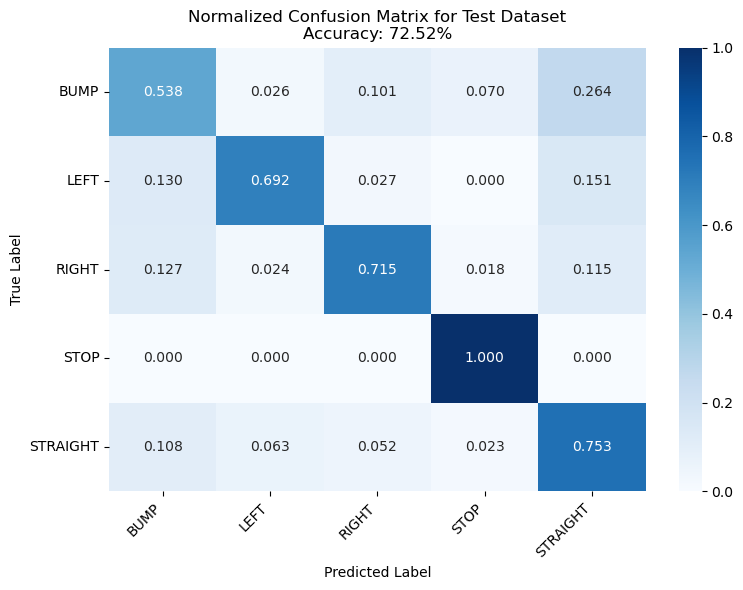

Accuracy: 72.52213653%


In [41]:
# Get the class labels
classes = label_encoder.classes_

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

y_pred_classes = np.array(all_preds)
y_test_categorical = np.array(all_labels)

print("Shape of y_pred_classes is", y_pred_classes.shape)
print("Shape of y_test_categorical is", y_test_categorical.shape)

# Ensure confusion_matrix uses the full set of labels in the correct order
conf_matrix = confusion_matrix(y_test_categorical, y_pred_classes, labels=np.arange(len(classes)))

# Calculate accuracy
accuracy = accuracy_score(y_test_categorical, y_pred_classes)

# Normalize the confusion matrix by row (handle possible zero-row sums)
row_sums = conf_matrix.sum(axis=1, keepdims=True)
conf_matrix_normalized = conf_matrix.astype('float') / np.where(row_sums == 0, 1, row_sums)

# Plot the confusion matrix using seaborn with readable label names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=classes, yticklabels=classes, cbar=True)
plt.title('Normalized Confusion Matrix for Test Dataset\nAccuracy: {:.2%}'.format(accuracy))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"Accuracy: {accuracy * 100:0.8f}%")


Shape of y_pred_classes is (67798,)
Shape of y_train_categorical is (67798,)


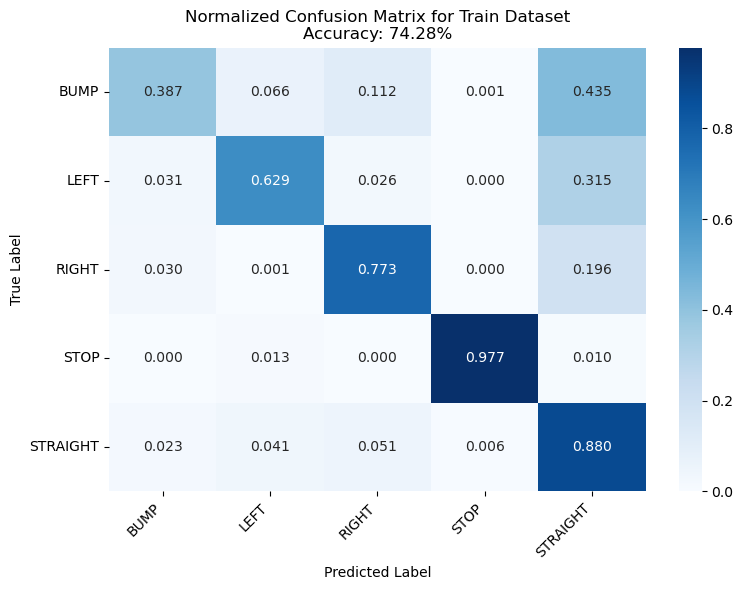

Accuracy: 74.28242721%


In [42]:
# Get the class labels
classes = label_encoder.classes_

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on training set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

y_pred_classes = np.array(all_preds)
y_train_categorical = np.array(all_labels)

print("Shape of y_pred_classes is", y_pred_classes.shape)
print("Shape of y_train_categorical is", y_train_categorical.shape)

# Ensure confusion_matrix uses the full set of labels in the correct order
conf_matrix = confusion_matrix(y_train_categorical, y_pred_classes, labels=np.arange(len(classes)))

# Calculate accuracy
accuracy = accuracy_score(y_train_categorical, y_pred_classes)

# Normalize the confusion matrix by row (handle possible zero-row sums)
row_sums = conf_matrix.sum(axis=1, keepdims=True)
conf_matrix_normalized = conf_matrix.astype('float') / np.where(row_sums == 0, 1, row_sums)

# Plot the confusion matrix using seaborn with readable label names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=classes, yticklabels=classes, cbar=True)
plt.title('Normalized Confusion Matrix for Train Dataset\nAccuracy: {:.2%}'.format(accuracy))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"Accuracy: {accuracy * 100:0.8f}%")


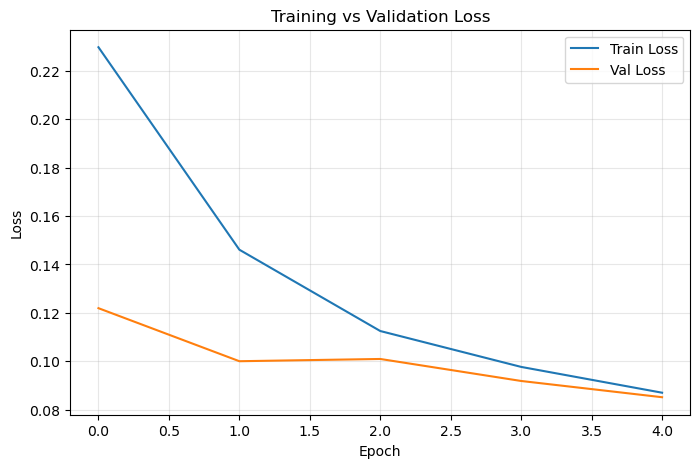

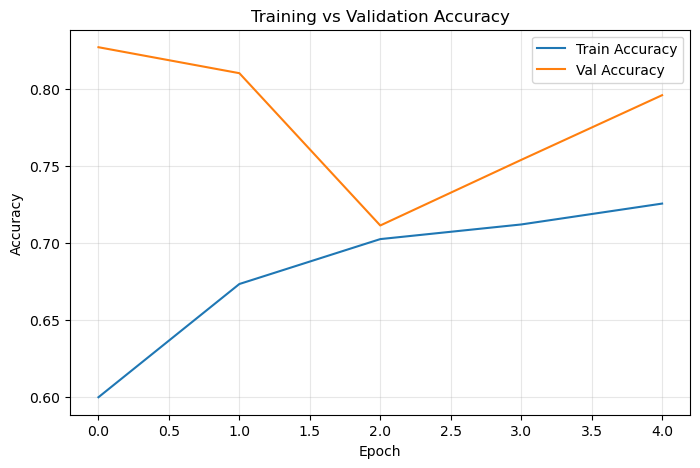

In [43]:
if 'history' in locals() and len(history['train_loss']) > 0:
    plt.figure(figsize=(8,5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("⚠️ Please run the model training cell (cell 5) first to generate the history object.")
